In [3]:
import torch  # 导入PyTorch库
import torch.nn as nn  # 导入PyTorch神经网络模块
import math  # 导入数学函数库
from torch.nn import functional as F  # 导入PyTorch函数式API

# 定义相对位置编码模块，相对位置编码是有参数的，可训练的
class RelativePositionEmbedding(nn.Module):
    def __init__(self, max_seq_len: int, embedding_dim: int):
        super().__init__()  # 调用父类初始化方法
        self.max_seq_len = max_seq_len  # 最大序列长度
        self.embedding_dim = embedding_dim  # 嵌入维度
        self.relative_positions = nn.Parameter(torch.randn(max_seq_len * 2 - 1, embedding_dim))  # 创建相对位置嵌入参数，密集向量矩阵，max_seq_len * 2 - 1是相对位置矩阵的行数，embedding_dim是相对位置嵌入参数的列数
    
    def forward(self, seq_len: int):
        relative_positions_matrix = self._generate_relative_positions_matrix(seq_len)  # 生成相对位置矩阵
        relative_embeddings = F.embedding(relative_positions_matrix, self.relative_positions)  # 获取相对位置嵌入,F.embedding的作用是根据索引获取对应的嵌入，索引是相对位置矩阵，嵌入是相对位置嵌入参数
        return relative_embeddings  # 返回相对位置嵌入
    
    def _generate_relative_positions_matrix(self, seq_len: int):
        range_vec = torch.arange(seq_len)  # 创建序列长度范围向量
        range_matrix = range_vec.unsqueeze(0).expand(seq_len, seq_len)  # 扩展为矩阵
        distance_matrix = range_matrix - range_matrix.t()  # 计算位置差距矩阵
        distance_matrix = distance_matrix + self.max_seq_len - 1  # 将负值偏移为非负值
        return distance_matrix  # 返回相对位置矩阵

# 定义多头注意力模块
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, max_seq_len: int):
        super().__init__()  # 调用父类初始化方法
        self.embed_dim = embed_dim  # 嵌入维度
        self.num_heads = num_heads  # 注意力头数
        self.head_dim = embed_dim // num_heads  # 每个头的维度
        self.q_proj = nn.Linear(embed_dim, embed_dim)  # 查询向量的线性投影
        self.k_proj = nn.Linear(embed_dim, embed_dim)  # 键向量的线性投影
        self.v_proj = nn.Linear(embed_dim, embed_dim)  # 值向量的线性投影
        self.rel_pos_embeddings = RelativePositionEmbedding(max_seq_len, self.head_dim)  # 相对位置编码
        self.out_proj = nn.Linear(embed_dim, embed_dim)  # 输出的线性投影
    
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor):
        batch_size, seq_len, embed_dim = query.size()  # 获取输入张量的形状
        
        # 投影并重塑为多头形式
        query = self.q_proj(query).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        key = self.k_proj(key).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        value = self.v_proj(value).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        
        # 计算标准注意力分数
        attention_scores = torch.matmul(query, key.transpose(-1, -2))  # (batch_size, num_heads, seq_len, seq_len)
        
        # 获取相对位置嵌入并添加到注意力分数中,走forward方法
        rel_pos_embeddings = self.rel_pos_embeddings(seq_len)  # (seq_len, seq_len, head_dim)
        
        # 计算相对位置注意力分数
        # 方法1：使用einsum进行高效计算
        rel_attention_scores = torch.einsum('bhld,lrd->bhlr', query, rel_pos_embeddings)  # (batch_size, num_heads, seq_len, seq_len)
        
        # 添加相对位置信息到注意力分数
        attention_scores += rel_attention_scores
        
        # 缩放注意力分数
        attention_scores = attention_scores / math.sqrt(self.head_dim)  # 缩放注意力分数
        
        # 计算注意力权重
        attention_weights = F.softmax(attention_scores, dim=-1)  # 计算注意力权重
        
        # 应用注意力权重
        output = torch.matmul(attention_weights, value)  # (batch_size, num_heads, seq_len, head_dim)
        
        # 重塑输出
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)  # (batch_size, seq_len, embed_dim)
        
        # 输出投影
        output = self.out_proj(output)  # 输出投影
        return output  # 返回最终输出

# 示例使用
max_seq_len = 10  # 设置最大序列长度
embed_dim = 64  # 设置嵌入维度
num_heads = 4  # 设置注意力头数
batch_size = 2  # 设置批次大小
seq_len = 5  # 设置序列长度

query = torch.randn(batch_size, seq_len, embed_dim)  # 创建随机查询张量
key = torch.randn(batch_size, seq_len, embed_dim)  # 创建随机键张量
value = torch.randn(batch_size, seq_len, embed_dim)  # 创建随机值张量

attention = MultiHeadAttention(embed_dim, num_heads, max_seq_len)  # 实例化多头注意力模块

# 测试各个组件
print("相对位置矩阵:")
print(attention.rel_pos_embeddings._generate_relative_positions_matrix(5))  # 打印相对位置矩阵
print(f"相对位置嵌入参数形状: {attention.rel_pos_embeddings.relative_positions.shape}")  # 打印相对位置嵌入形状
print(f"序列长度为5的相对位置嵌入形状: {attention.rel_pos_embeddings(5).shape}")  # 打印序列长度为5的相对位置嵌入形状

# 计算注意力输出
output = attention(query, key, value)  # 计算注意力输出
print(f"输出形状: {output.shape}")  # 输出形状为 (batch_size, seq_len, embed_dim)

相对位置矩阵:
tensor([[ 9, 10, 11, 12, 13],
        [ 8,  9, 10, 11, 12],
        [ 7,  8,  9, 10, 11],
        [ 6,  7,  8,  9, 10],
        [ 5,  6,  7,  8,  9]])
相对位置嵌入参数形状: torch.Size([19, 16])
序列长度为5的相对位置嵌入形状: torch.Size([5, 5, 16])
输出形状: torch.Size([2, 5, 64])


# 旋转位置编码

测试旋转位置编码(RoPE)
输入形状: torch.Size([2, 10, 128])
输出形状: torch.Size([2, 10, 128])
注意力权重形状: torch.Size([2, 8, 10, 10])

测试相对位置特性:
序列1注意力权重形状: torch.Size([1, 8, 5, 5])
序列2注意力权重形状: torch.Size([1, 8, 7, 7])
RoPE有助于保持序列中元素的相对位置关系

比较RoPE与绝对位置编码:
RoPE优势:
1. 更好的相对位置建模
2. 对序列长度的泛化能力更强
3. 在长序列上性能更稳定

绝对位置编码特点:
1. 直接添加到输入embeddings
2. 简单但可能丢失相对位置信息
3. 对序列长度敏感


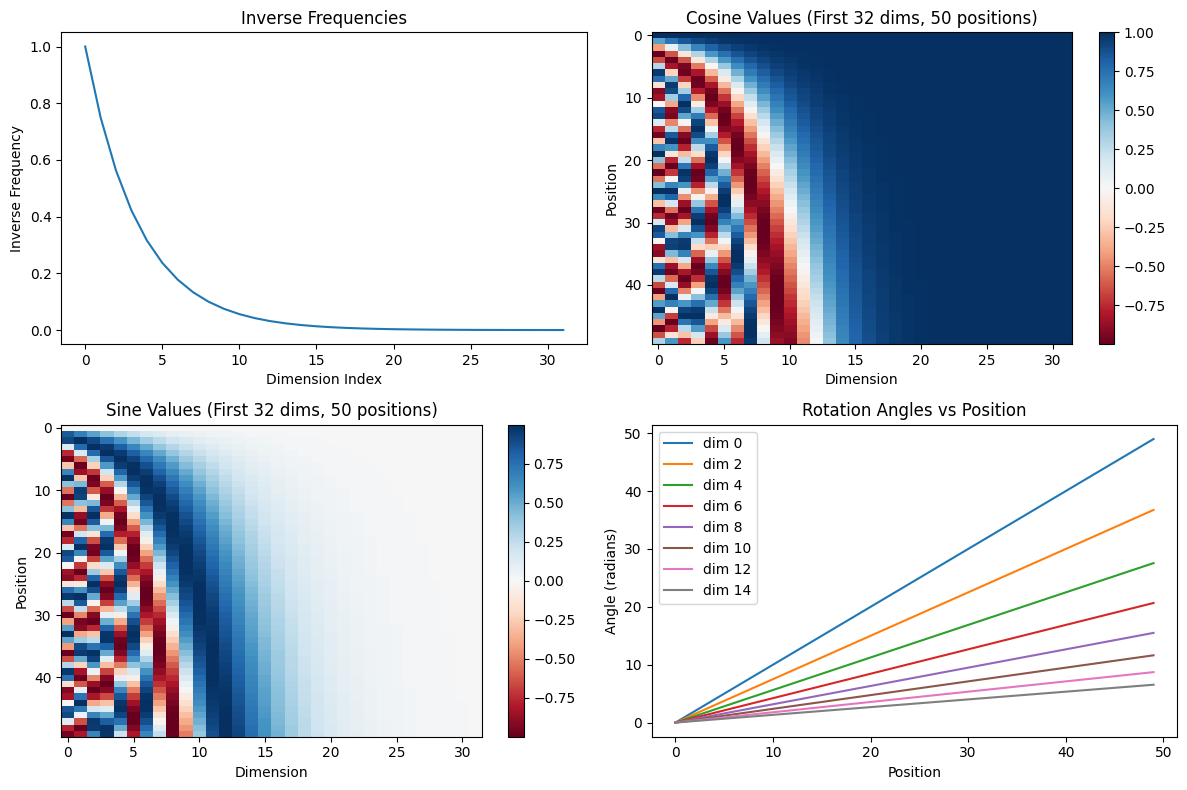


旋转位置编码(RoPE)示例完成！


In [ ]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np

class RotaryPositionalEmbedding(nn.Module):
    """
    旋转位置编码(RoPE - Rotary Position Embedding)
    
    RoPE的核心思想是通过旋转矩阵来编码位置信息，相对于绝对位置编码，
    RoPE能够更好地捕捉序列中元素的相对位置关系。
    """
    
    def __init__(self, dim, max_position_embeddings=2048, base=10000):
        super().__init__()
        self.dim = dim  # 特征维度
        self.max_position_embeddings = max_position_embeddings # 最大序列长度
        self.base = base
        
        # 预计算频率
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim)) 
        self.register_buffer('inv_freq', inv_freq) # 注册缓存
        
        # 预计算旋转矩阵
        self._set_cos_sin_cache(max_position_embeddings) # 预计算cos和sin值
    
    def _set_cos_sin_cache(self, seq_len):
        """预计算cos和sin值"""
        # 位置索引
        t = torch.arange(seq_len, dtype=self.inv_freq.dtype, device=self.inv_freq.device) 
        
        # 计算角度: position * inv_freq
        freqs = torch.outer(t, self.inv_freq)  # [seq_len, dim//2]
        
        # 拼接以匹配head_dim
        emb = torch.cat((freqs, freqs), dim=-1)  # [seq_len, dim]
        
        # 缓存cos和sin值
        self.register_buffer('cos_cached', emb.cos())
        self.register_buffer('sin_cached', emb.sin())
    
    def forward(self, x, seq_len=None):
        """
        应用旋转位置编码
        
        Args:
            x: 输入张量 [batch_size, seq_len, num_heads, head_dim]
            seq_len: 序列长度
        
        Returns:
            应用RoPE后的张量
        """
        if seq_len is None:
            seq_len = x.shape[1] # 序列长度
        
        # 如果序列长度超过缓存，重新计算
        if seq_len > self.cos_cached.shape[0]:
            self._set_cos_sin_cache(seq_len)
        
        # 获取对应长度的cos和sin
        cos = self.cos_cached[:seq_len]
        sin = self.sin_cached[:seq_len]
        
        # 应用旋转位置编码
        return self.apply_rotary_pos_emb(x, cos, sin)
    
    def apply_rotary_pos_emb(self, x, cos, sin):
        """应用旋转位置编码的核心函数"""
        # x: [batch_size, seq_len, num_heads, head_dim]
        # cos, sin: [seq_len, head_dim]
        
        # 调整cos和sin的维度以匹配x
        # 从 [seq_len, head_dim] 扩展到 [1, seq_len, 1, head_dim]
        cos = cos.unsqueeze(0).unsqueeze(2)  # [1, seq_len, 1, head_dim]
        sin = sin.unsqueeze(0).unsqueeze(2)  # [1, seq_len, 1, head_dim]
        
        # 将x分成两部分进行旋转
        x1, x2 = x[..., ::2], x[..., 1::2]
        
        # 旋转操作: 复数乘法的实现
        # (a + bi) * (cos + sin*i) = (a*cos - b*sin) + (a*sin + b*cos)i
        rotated_x1 = x1 * cos[..., ::2] - x2 * sin[..., ::2] # 偶数位置
        rotated_x2 = x1 * sin[..., 1::2] + x2 * cos[..., 1::2] # 奇数位置
        
        # 重新交错排列
        rotated_x = torch.zeros_like(x)
        rotated_x[..., ::2] = rotated_x1 # 偶数位置
        rotated_x[..., 1::2] = rotated_x2 # 奇数位置
        
        return rotated_x

class MultiHeadAttentionWithRoPE(nn.Module):
    """带有RoPE的多头注意力机制"""
    
    def __init__(self, d_model, num_heads, max_position_embeddings=2048):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        assert self.head_dim * num_heads == d_model
        
        self.q_proj = nn.Linear(d_model, d_model) # 线性变换
        self.k_proj = nn.Linear(d_model, d_model) # 线性变换
        self.v_proj = nn.Linear(d_model, d_model) # 线性变换
        self.o_proj = nn.Linear(d_model, d_model) # 线性变换
        
        # 旋转位置编码
        self.rotary_emb = RotaryPositionalEmbedding(
            self.head_dim, max_position_embeddings
        )
        
        self.scale = self.head_dim ** -0.5 # 缩放因子
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape # 批量大小，序列长度，特征维度
        
        # 线性变换
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        
        # 重塑为多头
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # 应用旋转位置编码
        q = self.rotary_emb(q, seq_len) # [batch_size, seq_len, num_heads, head_dim]
        k = self.rotary_emb(k, seq_len) # [batch_size, seq_len, num_heads, head_dim]
        
        # 转换维度用于注意力计算
        q = q.transpose(1, 2)  # [batch_size, num_heads, seq_len, head_dim]
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # 计算注意力分数
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale # [batch_size, num_heads, seq_len, seq_len]
        
        # 应用掩码
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9) # [batch_size, num_heads, seq_len, seq_len]
        
        # 注意力权重
        attn_weights = torch.softmax(scores, dim=-1) # [batch_size, num_heads, seq_len, seq_len]
        
        # 应用注意力权重
        attn_output = torch.matmul(attn_weights, v) # [batch_size, num_heads, seq_len, head_dim]
        
        # 重新组合头
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.d_model
        )
        
        # 输出投影
        output = self.o_proj(attn_output) # [batch_size, seq_len, d_model]
        
        return output, attn_weights # [batch_size, seq_len, d_model], [batch_size, num_heads, seq_len, seq_len]

def visualize_rope():
    """可视化RoPE的频率特性"""
    dim = 64
    max_len = 100
    
    rope = RotaryPositionalEmbedding(dim, max_len)
    
    # 创建示例输入
    x = torch.randn(1, max_len, 1, dim)
    
    # 应用RoPE
    rotated_x = rope(x)
    
    # 可视化频率
    plt.figure(figsize=(12, 8))
    
    # 绘制频率分布
    plt.subplot(2, 2, 1)
    plt.plot(rope.inv_freq.numpy())
    plt.title('Inverse Frequencies')
    plt.xlabel('Dimension Index')
    plt.ylabel('Inverse Frequency')
    
    # 绘制cos值
    plt.subplot(2, 2, 2)
    cos_matrix = rope.cos_cached[:50, :32].numpy()
    plt.imshow(cos_matrix, cmap='RdBu', aspect='auto')
    plt.title('Cosine Values (First 32 dims, 50 positions)')
    plt.xlabel('Dimension')
    plt.ylabel('Position')
    plt.colorbar()
    
    # 绘制sin值
    plt.subplot(2, 2, 3)
    sin_matrix = rope.sin_cached[:50, :32].numpy()
    plt.imshow(sin_matrix, cmap='RdBu', aspect='auto')
    plt.title('Sine Values (First 32 dims, 50 positions)')
    plt.xlabel('Dimension')
    plt.ylabel('Position')
    plt.colorbar()
    
    # 绘制旋转角度随位置的变化
    plt.subplot(2, 2, 4)
    positions = torch.arange(50)
    angles = torch.einsum('i,j->ij', positions.float(), rope.inv_freq[:8]) 
    for i in range(8):
        plt.plot(positions, angles[:, i], label=f'dim {i*2}')
    plt.title('Rotation Angles vs Position')
    plt.xlabel('Position')
    plt.ylabel('Angle (radians)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def test_rope_example():
    """测试RoPE的基本功能"""
    print("测试旋转位置编码(RoPE)")
    
    # 参数设置
    batch_size = 2
    seq_len = 10
    d_model = 128
    num_heads = 8
    
    # 创建模型
    attention = MultiHeadAttentionWithRoPE(d_model, num_heads)
    
    # 创建输入
    x = torch.randn(batch_size, seq_len, d_model)
    
    # 前向传播
    output, attn_weights = attention(x)
    
    print(f"输入形状: {x.shape}") # [batch_size, seq_len, d_model]
    print(f"输出形状: {output.shape}") # [batch_size, seq_len, d_model]
    print(f"注意力权重形状: {attn_weights.shape}") # [batch_size, num_heads, seq_len, seq_len]
    
    # 测试相对位置特性
    print("\n测试相对位置特性:")
    
    # 创建两个序列：一个是另一个的平移版本
    seq1 = torch.randn(1, 5, d_model)
    seq2 = torch.cat([torch.zeros(1, 2, d_model), seq1], dim=1)  # 向右平移2位
    
    # 计算注意力
    _, attn1 = attention(seq1)
    _, attn2 = attention(seq2)
    
    print(f"序列1注意力权重形状: {attn1.shape}") # [batch_size, num_heads, seq_len, seq_len]
    print(f"序列2注意力权重形状: {attn2.shape}") # [batch_size, num_heads, seq_len, seq_len]
    
    # RoPE应该保持相对位置关系
    print("RoPE有助于保持序列中元素的相对位置关系")

def compare_with_absolute_pe():
    """比较RoPE与绝对位置编码"""
    print("\n比较RoPE与绝对位置编码:")
    
    d_model = 64
    seq_len = 20
    
    # 创建RoPE
    rope = RotaryPositionalEmbedding(d_model, seq_len)
    
    # 创建绝对位置编码
    position = torch.arange(seq_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * 
                        (-math.log(10000.0) / d_model))
    
    abs_pe = torch.zeros(seq_len, d_model)
    abs_pe[:, 0::2] = torch.sin(position * div_term)
    abs_pe[:, 1::2] = torch.cos(position * div_term)
    
    print("RoPE优势:")
    print("1. 更好的相对位置建模")
    print("2. 对序列长度的泛化能力更强")
    print("3. 在长序列上性能更稳定")
    
    print("\n绝对位置编码特点:")
    print("1. 直接添加到输入embeddings")
    print("2. 简单但可能丢失相对位置信息")
    print("3. 对序列长度敏感")

if __name__ == "__main__":
    # 运行测试
    test_rope_example()
    
    # 比较不同位置编码方法
    compare_with_absolute_pe()
    
    # 可视化（需要matplotlib）
    try:
        visualize_rope()
    except ImportError:
        print("需要安装matplotlib来运行可视化: pip install matplotlib")
    
    print("\n旋转位置编码(RoPE)示例完成！")

 右上图：Cosine Values (First 32 dims, 50 positions)
标题：Cosine Values（前 32 个维度，前 50 个位置）

横轴：维度（Dimension）

纵轴：位置（Position）

色彩：cos 值的大小（-1 ~ 1）

✅ 含义：
展示了每个位置和维度对应的 cos(θ) 值分布。

可以看到：

越靠左（低维），周期越短（频率高）

越靠右（高维），cos 变化更缓慢（频率低）

说明：RoPE 对不同维度使用不同频率的正余弦编码，以组合出丰富的位置特征

🔶 左下图：Sine Values (First 32 dims, 50 positions)
标题：Sine Values（前 32 个维度，前 50 个位置）

格式和右上图一样，只不过是展示的 sin 值。

✅ 含义：
与 cos 一样，sin 值也是周期性的，频率递减。

这些 sin 和 cos 会被用于对 query/key 的不同维度进行“复数式旋转”（即二维旋转）。